In [2]:
import os
import pandas as pd
import numpy as np
import mat73
from sklearn import svm
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA

In [5]:
#%% step 1: prepare the feature vectors and labels
# get the path of the current code

path_curr = os.getcwd()

file_data = os.path.join(path_curr,'/data/data_features.mat')
file_label = os.path.join(path_curr,'/data/labels.xlsx')

# read the label file and get the label of each sample
data_label = pd.read_excel(file_label, engine='openpyxl')
labels_each = data_label['network_id']
labels = list(labels_each)*4

y = labels

# load data of feature vectors
data_all = mat73.loadmat(file_data )
data = data_all['TS_DataMat']


#%% step 2: run the classification using all the features
data_all_features = data
print ('classify using all the features')
accuracy_all_features, f1_all_features = svm_classify(data_all_features,labels)

#%% step 3: run the classification using the part of the features

# identify distinct values by feature
df = pd.DataFrame(data, columns = list(np.arange(1,data.shape[1]+1)))
distinct_counter = df.apply(lambda x: len(x.unique()))

# sort the distinct_counter based on the unique number
distinct_counter.sort_values(ascending = False, inplace=True)

cols_index = list(distinct_counter.index)
# choose the first * features for classification
for feature_part_num in range(500,7000,500):
    data_part = df[cols_index[0:feature_part_num]]

    # classify
    print ('classify using %s features'%(feature_part_num))
    accuracy_part_features, f1_part_features = svm_classify(data_part.values, labels)
    break


ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)


classify using all the features
Accuracy (Polynomial Kernel):  34.69
F1 (Polynomial Kernel):  34.02
       
classify using 500 features
Accuracy (Polynomial Kernel):  13.12
F1 (Polynomial Kernel):  5.90
       


In [15]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data_all_features,labels, train_size=0.80, test_size=0.20,
                                                                        random_state=101)
clf = RandomForestClassifier(max_depth=8, random_state=0)
clf.fit(X_train, y_train)
poly_pred = clf.predict(X_test)

# calculate the accuracy and f1 scores
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print(poly_accuracy, poly_f1)

0.315625 0.3020746978199694


#### Check the importance of each feature

* most of the features are not important at all in the eyes of the random forest model as you can see the peak in the histogram below

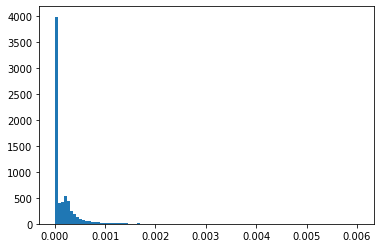

In [44]:
import matplotlib.pyplot as plt
_ = plt.hist(clf.feature_importances_, bins=100)

#### Sort the features based on feature importance and then select the top k to train the model

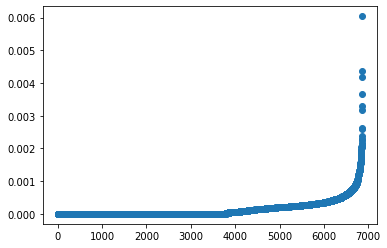

In [46]:
idxes = np.argsort(clf.feature_importances_)
plt.scatter(range(len(idxes)), clf.feature_importances_[idxes])

#### Use the top k features to train again

In [56]:
num_of_features = 40
X_train, X_test, y_train, y_test = model_selection.train_test_split(data_all_features[:, idxes[-num_of_features:]],labels, 
                                                                    train_size=0.80, test_size=0.20,
                                                                        random_state=101)
clf = RandomForestClassifier(max_depth=8, random_state=0)
clf.fit(X_train, y_train)
poly_pred = clf.predict(X_test)

# calculate the accuracy and f1 scores
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print(poly_accuracy, poly_f1)

0.3125 0.3050070537302349


#### Using 40 features, it is still predictable. It is feasible to check what the 40 features are one by one. If 40 is still too many, use less features as long as the prediction performance is faily decent

In [61]:
import lightgbm as lgb

In [62]:
num_class = len(np.unique(labels))

In [69]:
labels = [i-1 for i in labels]

In [73]:
max(labels)

16

In [144]:
params_k = {
            'boosting_type': 'gbdt',
            'objective': 'multiclass',
            'num_class': num_class,
            'subsample': 0.5,
            'subsample_freq': 1,
            'learning_rate': 0.03,
            'num_leaves': 2**5-1,
            'min_data_in_leaf': 2**5-1,
            'feature_fraction': 0.5,
            'max_bin': 100,
            'n_estimators': 10,
            'boost_from_average': False,
            "random_seed":42}

In [145]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data_all_features[:, idxes[-num_of_features:]],labels, 
                                                                    train_size=0.80, test_size=0.20,
                                                                        random_state=101)

train_data = lgb.Dataset(data=X_train,
                         label=y_train,
                         free_raw_data=False)

In [146]:
model_gbm = lgb.train(params_k, train_data,  verbose_eval=0)

/home/bizon/anaconda3/envs/janet/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [147]:
poly_pred = model_gbm.predict(X_test).argmax(axis=1)

# calculate the accuracy and f1 scores
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print(poly_accuracy, poly_f1)

0.28125 0.27496052818724576


In [148]:
poly_pred = model_gbm.predict(X_test).argmax(axis=1)

# calculate the accuracy and f1 scores
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print(poly_accuracy, poly_f1)

0.28125 0.27496052818724576


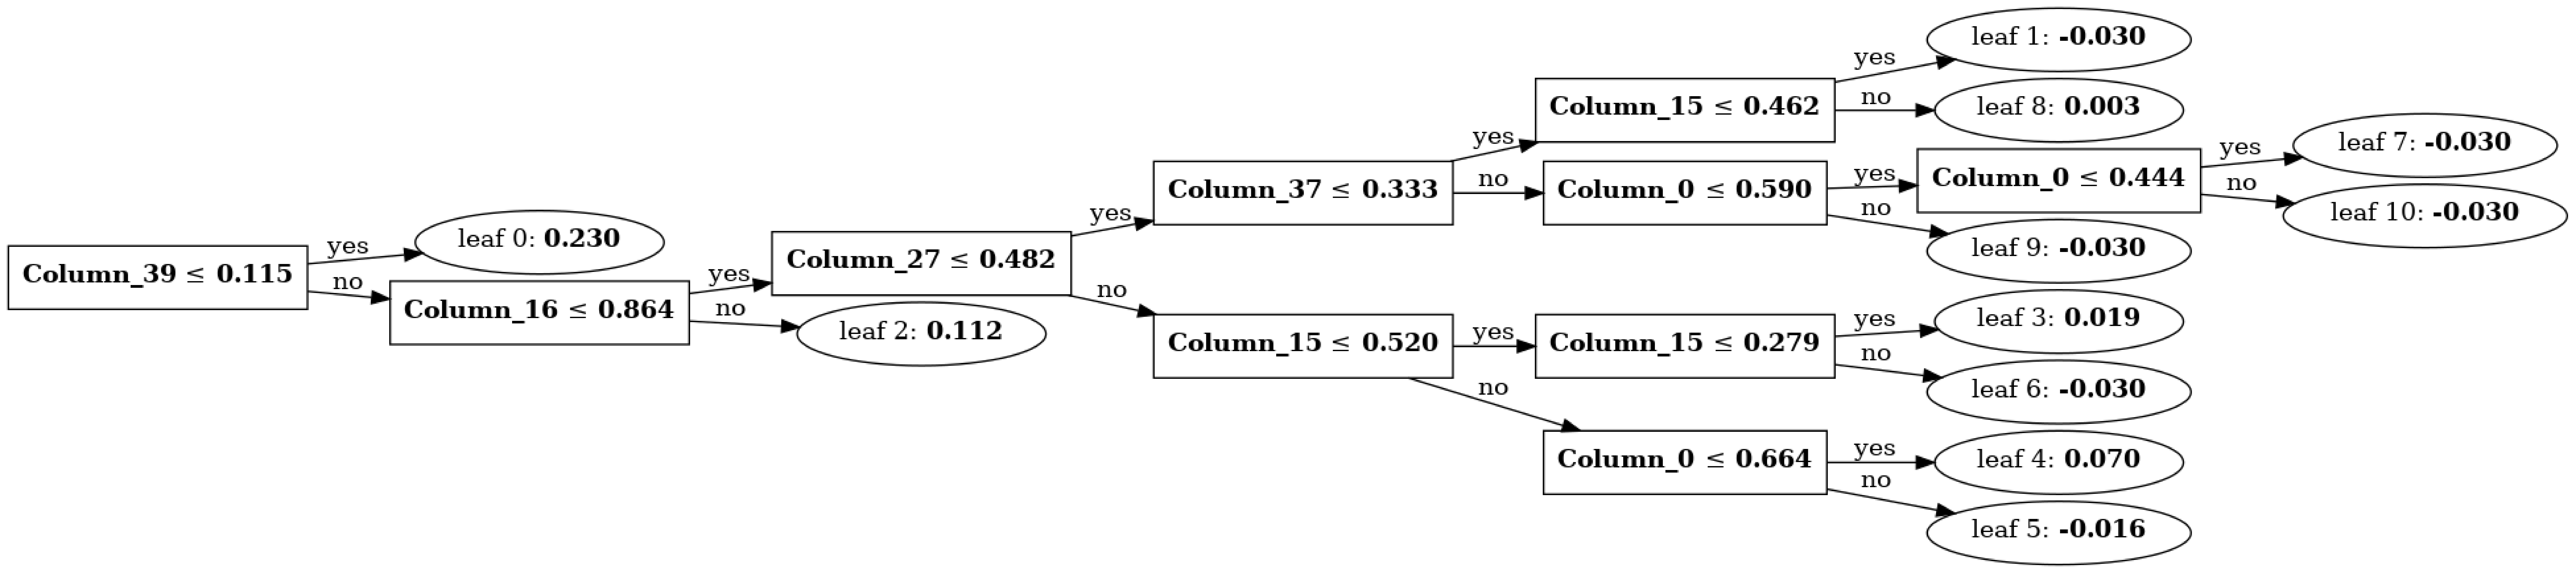

In [149]:
import matplotlib
lgb.plot_tree(model_gbm, tree_index=0) # plot the first tree

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(250, 200)